In [1]:
%matplotlib inline
import sys
import os
import numpy as np
import pandas as pd

import datetime
import scipy
import seaborn as sb
import matplotlib.pyplot as plt
import anndata
import igraph as ig
import leidenalg

os.chdir("ILCs_Olga_202211/")
plt.rcParams['figure.figsize']=(5,5) #rescale figures

# Read Data

In [2]:
datapath = "Data_2024/"
results_path = "results/"
results_file = 'results/Preprocessed_2024.h5ad'  
filenames = ["ILC_LK_CF_M1324310.xlsx","ILC_LK_EM_M1174159.xlsx","ILC_LK_EM_M1324326.xlsx",
             "ILC_LK_FI_M1324298.xlsx","ILC_LK_FI_M1324314.xlsx","ILC_LK_HD_M1324304.xlsx",
             "ILC_LU_CF_M1324308.xlsx","ILC_LU_FI_M1174139.xlsx",
             "ILC_LU_FI_M1324312.xlsx","ILC_LU_HD_M1174155.xlsx","ILC_LU_EM_M1174141.xlsx",]
sample_string = ["LK_CF_M1324310","LK_EM_M1174159","LK_EM_M1324326","LK_FI_M1324298",
                 "LK_FI_M1324314","LK_HD_M1324304","LU_CF_M1324308",
                 "LU_FI_M1174139","LU_FI_M1324312","LU_HD_M1174155","LU_EM_M1174141",]

batch = ["batch1"]*len(filenames)
sample_id = list(range(len(filenames)))

identity_markers = ["CD127-PerCP-Cy5.5","CD94-FITC","CD117-PE",
                    "CD294-PerCP-Cy5.5","Lineage-Mix-FITC","CD45"]

activation_markers = ["CD336-PE","CD279-FITC","Il-23R-FITC",
                      "CD196-PE","CD154-PE", "CD278-FITC",
                      "CD254-PE","B7-H2, CD275","CD161-PerCP-Cy5.5",
                      "CD253-PE","BAFF","CD40","CD152-PerCP-Cy5.5",
                      "CD80-PE"]

In [3]:
df = pd.read_excel(datapath+filenames[0])
df["sample"] = [sample_string[0]]*len(df)
df.reset_index(inplace=True, drop=True)
    
print("not inculded: ", [item for item in df.columns if item not in identity_markers+activation_markers]) 
print("not found: ", [item for item in  identity_markers+activation_markers if item not in df.columns])
df.index = df["CellID"].astype("str")+"_"+df["sample"].astype("str")

not inculded:  ['CellID', 'Position', 'XPos', 'YPos', 'Size', 'sample']
not found:  []


In [4]:
# read additional data
for index,filepath in enumerate(filenames[1:], start=1):
    print(index, filepath)
    with open(datapath+filepath,mode="rb") as excel_file:
        df_tmp = pd.read_excel(excel_file)
    df_tmp["sample"] = [sample_string[index]]*len(df_tmp)
    if "CD294" in df_tmp.columns:
        df_tmp.rename({'CD294': 'CD294-PerCP-Cy5.5'}, axis=1, inplace=True)
    if "CD127" in df_tmp.columns:
        if 'CD127-PerCP-Cy5.5' in df_tmp.columns:                
            df_tmp.rename({'CD127-PerCP-Cy5.5':'CD127-PerCP-Cy5.5_old'}, axis=1, inplace=True)
        df_tmp.rename({'CD127': 'CD127-PerCP-Cy5.5'}, axis=1, inplace=True)
    if "CD117" in df_tmp.columns:
        df_tmp.rename({'CD117': 'CD117-PE'}, axis=1, inplace=True)
    if "Lineage-Mix" in df_tmp.columns:
        df_tmp.rename({'Lineage-Mix': 'Lineage-Mix-FITC'}, axis=1, inplace=True)
    df_tmp.reset_index(inplace=True, drop=True)
    df_tmp.index = df_tmp["CellID"].astype("str")+"_"+df_tmp["sample"].astype("str")
    print("not inculded: ", [item for item in df_tmp.columns if item not in identity_markers+activation_markers]) 
    print("not found: ", [item for item in  identity_markers+activation_markers if item not in df_tmp.columns]) 
     
    df_tmp.reset_index(inplace=True, drop=True)
    df = pd.concat([df, df_tmp]) 

1 ILC_LK_EM_M1174159.xlsx
not inculded:  ['CellID', 'Position', 'XPos', 'YPos', 'Size', 'sample']
not found:  []
2 ILC_LK_EM_M1324326.xlsx
not inculded:  ['CellID', 'Position', 'XPos', 'YPos', 'Size', 'sample']
not found:  []
3 ILC_LK_FI_M1324298.xlsx
not inculded:  ['CellID', 'Position', 'XPos', 'YPos', 'Size', 'sample']
not found:  []
4 ILC_LK_FI_M1324314.xlsx
not inculded:  ['CellID', 'Position', 'XPos', 'YPos', 'Size', 'sample']
not found:  []
5 ILC_LK_HD_M1324304.xlsx
not inculded:  ['CellID', 'Position', 'XPos', 'YPos', 'Size', 'sample']
not found:  []
6 ILC_LU_CF_M1324308.xlsx
not inculded:  ['CellID', 'Position', 'XPos', 'YPos', 'Size', 'sample']
not found:  []
7 ILC_LU_FI_M1174139.xlsx
not inculded:  ['CellID', 'Position', 'XPos', 'YPos', 'Size', 'sample']
not found:  []
8 ILC_LU_FI_M1324312.xlsx
not inculded:  ['CellID', 'Position', 'XPos', 'YPos', 'Size', 'sample']
not found:  []
9 ILC_LU_HD_M1174155.xlsx
not inculded:  ['CellID', 'Position', 'XPos', 'YPos', 'Size', 'sample'

In [7]:
df[["organ","disease","id"]] = df["sample"].str.split("_", 2, expand=True)

#fill na with mean per column = Marker 
df = df.fillna(df.mean())
df

/tmp/ipykernel_3970451/4060216029.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df = df.fillna(df.mean())


,CellID,Position,XPos,YPos,Size,CD127-PerCP-Cy5.5,CD94-FITC,CD117-PE,CD336-PE,CD279-FITC,...,BAFF,CD40,CD152-PerCP-Cy5.5,CD80-PE,CD45,sample,CD127-PerCP-Cy5.5_old,organ,disease,id
306_LK_CF_M1324310,306,2,1267,166,9,2132,983,463.0,3089.042186,1618.714309,...,1527,2024.0,-61.0,-1036,14633.0,LK_CF_M1324310,-86.517647,LK,CF,M1324310
1023_LK_CF_M1324310,1023,7,752,495,9,1488,1596,106230.0,3089.042186,1618.714309,...,1683,1786.0,-104.0,-149,32932.0,LK_CF_M1324310,-86.517647,LK,CF,M1324310
580_LK_CF_M1324310,580,6,781,307,9,1554,-203,-496.0,3089.042186,1618.714309,...,2349,3884.0,-465.0,83,17669.0,LK_CF_M1324310,-86.517647,LK,CF,M1324310
83_LK_CF_M1324310,83,8,73,63,9,2269,557,204.0,3089.042186,1618.714309,...,1669,1145.0,51.0,-267,2354.0,LK_CF_M1324310,-86.517647,LK,CF,M1324310
1332_LK_CF_M1324310,1332,6,435,674,9,655,269,-213.0,3089.042186,1618.714309,...,460,921.0,232.0,365,8748.0,LK_CF_M1324310,-86.517647,LK,CF,M1324310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,45,26,716,610,13,8178,1755,87.0,498.000000,1261.000000,...,-518,1565.0,426.0,367,1385.0,LU_EM_M1174141,-395.000000,LU,EM,M1174141
81,39,26,141,527,13,36962,1516,191.0,0.000000,0.000000,...,-846,1542.0,381.0,147,1209.0,LU_EM_M1174141,-332.000000,LU,EM,M1174141
82,288,3,1023,230,13,22030,5531,864.0,789.000000,1461.000000,...,2899,6772.0,3677.0,155,1017.0,LU_EM_M1174141,-264.000000,LU,EM,M1174141
83,33,12,971,160,7,399857,834,407.0,-71.000000,828.000000,...,1779,29352.0,932.0,-10,1209.0,LU_EM_M1174141,7.000000,LU,EM,M1174141


<Axes: >

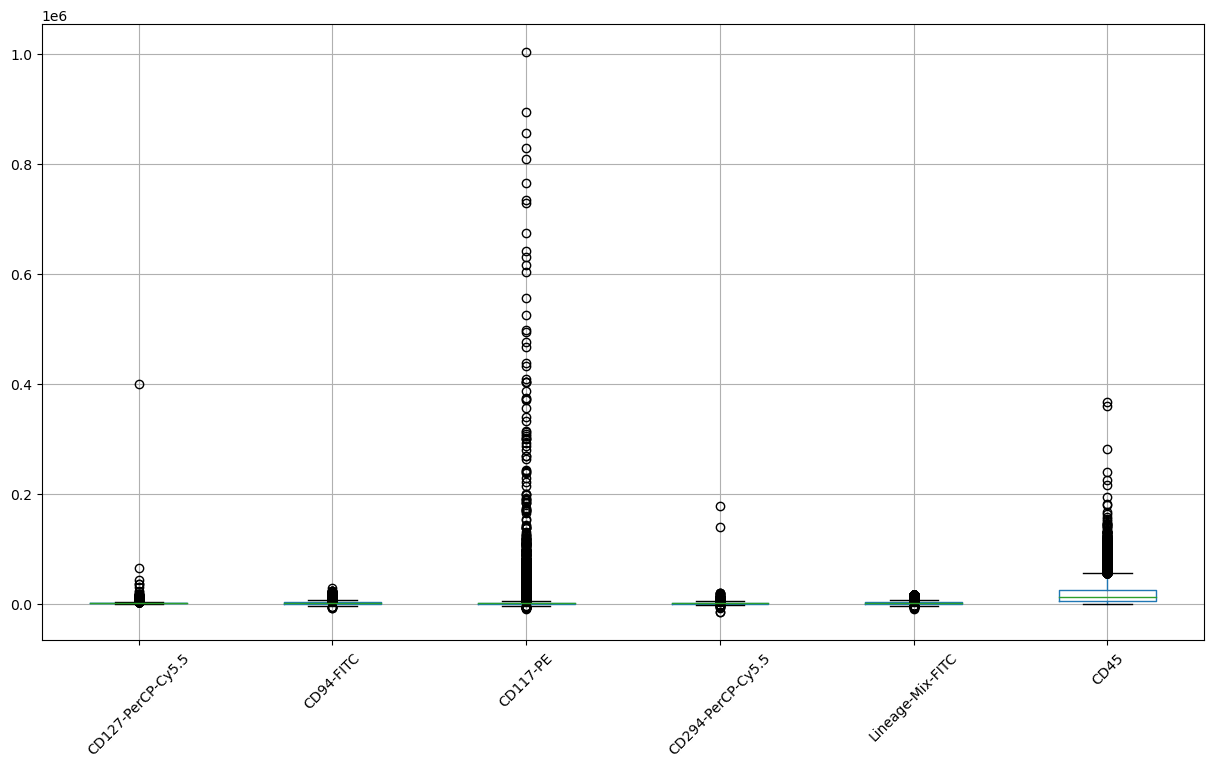

In [12]:
df_raw = df.copy()
#rawdata
df.boxplot(column=identity_markers, figsize=(15,8), rot=45)  

## log-transfomration (after shift (-1)*min)

<Axes: >

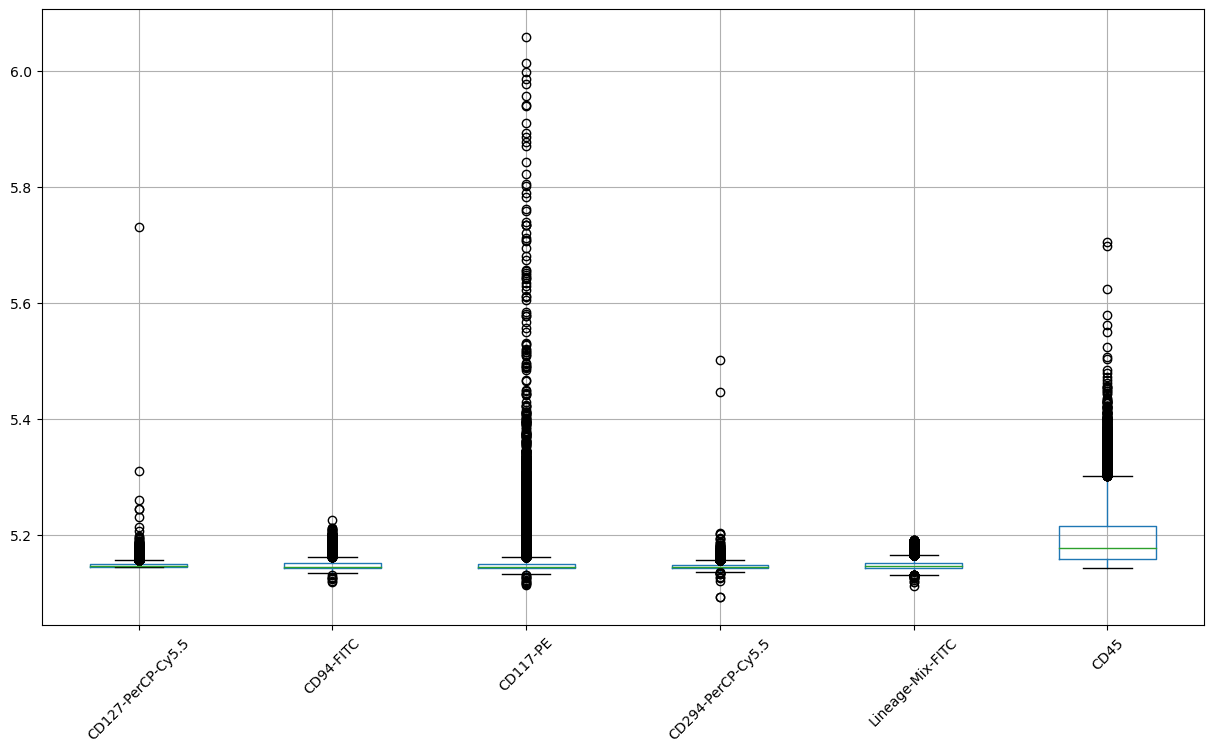

In [14]:
df[activation_markers+identity_markers] = np.log10(df[activation_markers+identity_markers]+(abs(minimum)+1))
#log transformed
df.boxplot(column=identity_markers, figsize=(15,8), rot=45)  

In [15]:
#merge raw and log data:
df = pd.concat([df, df_raw[activation_markers + identity_markers].add_suffix('_raw')], axis=1)
df[identity_markers] = np.nan_to_num(df[identity_markers])
#df.to_csv("data_df_normalized_2024.csv", na_rep='NA', index=False)

# Split by organ

## LK

In [35]:
df_lk = df[df["organ"] == "LK"]
del df_lk["group"]

In [36]:
from sklearn.neighbors import NearestNeighbors
import igraph
from array import array
import leidenalg

nbrs = NearestNeighbors(n_neighbors=int(15), algorithm='ball_tree').fit(df_lk[identity_markers])
distances, indices = nbrs.kneighbors(df_lk[identity_markers])
knn_sparse_matrix = nbrs.kneighbors_graph() #csr format

#convert to igraph
sources, targets = knn_sparse_matrix.nonzero()
weights = knn_sparse_matrix[sources, targets]
weights = (weights.A)[0] 
knn_graph = igraph.Graph(directed=True)
knn_graph.add_vertices(knn_sparse_matrix.shape[0])  # this adds adjacency.shape[0] vertices
knn_graph.add_edges(list(zip(sources, targets)))

#leiden-algo
partition = leidenalg.find_partition(knn_graph, leidenalg.RBConfigurationVertexPartition, 
                                     resolution_parameter = 0.1,
                                     n_iterations=-1, seed=0) #run until no further improvement 

groups = np.array(partition.membership)
df_lk["group"] = groups
#print(groups)
k = len(np.unique(groups)) #return k
print("Number of Clusters: ", k)

df_lk.disease  = df_lk.disease.astype("category")
df_lk.disease.cat.reorder_categories(['CF', 'EM', 'FI', 'HD'], inplace=True)
#df_lk.to_csv("data_lk_standardised_2024.csv")

Number of Clusters:  5


/tmp/ipykernel_1462226/3690424253.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lk["group"] = groups


### Cells per Cluster (data for Figure 3 B)

In [8]:
print("number of cells per cluster:")
df_lk['group'].value_counts()
df_lk.groupby(["disease", "group"]).count()["Size"]

number of cells per cluster:


disease  group
CF       0        4179
         1        1271
         2         529
         3        1402
         4          34
EM       0         163
         1         400
         2          70
         3        1429
         4          10
FI       0         216
         1         346
         2           6
         3         748
         4           1
HD       0        2255
         1        3224
         2        3895
         3         761
         4          12
Name: Size, dtype: int64

In [40]:
df_counts = pd.DataFrame(df_lk.groupby(["disease", "group"]).count()["Size"])
df_counts.reset_index(inplace=True)
df_counts["Size"] = pd.to_numeric(df_counts["Size"])
df_counts = df_counts.pivot_table(index='disease',columns='group')
df_counts.columns = df_counts.columns.get_level_values(1)
df_counts

group,0,1,2,3,4
disease,,,,,
CF,4179,1271,529,1402,34
EM,163,400,70,1429,10
FI,216,346,6,748,1
HD,2255,3224,3895,761,12


In [41]:
df_counts = pd.DataFrame(df_lk.groupby(["disease", "group"]).count()["Size"])
df_counts.reset_index(inplace=True)
df_counts["Size"] = pd.to_numeric(df_counts["Size"])
pd.crosstab(df_counts["disease"], df_counts["group"], values=df_counts["Size"], aggfunc=np.sum, normalize='columns').applymap(lambda x: "{0:.00f}%".format(100*x))

group,0,1,2,3,4
disease,,,,,
CF,61%,24%,12%,32%,60%
EM,2%,8%,2%,33%,18%
FI,3%,7%,0%,17%,2%
HD,33%,62%,87%,18%,21%


### UMAP (Figure 3A)

In [21]:
import umap.umap_ as umap
umap_2d_lk = umap.UMAP(n_components=2,random_state=42) # init='random', 
proj_2d_lk = umap_2d_lk.fit_transform(df_lk[identity_markers])

np.save('umap_lk.npy', proj_2d_lk) # save
#proj_2d_lk = np.load('umap_lk.npy') # load

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


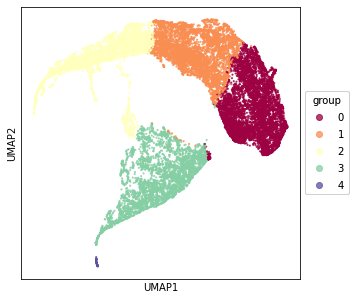

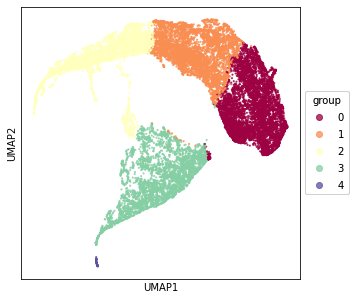

In [27]:
umap_plot(x=proj_2d_lk[:, 0], y=proj_2d_lk[:, 1], c=df_lk["group"], save="umap_lk_group.eps")
umap_plot(x=proj_2d_lk[:, 0], y=proj_2d_lk[:, 1], c=df_lk["group"], save="umap_lk_group.tif")

In [28]:
df_lk = df_lk.sort_values(by=["disease"])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


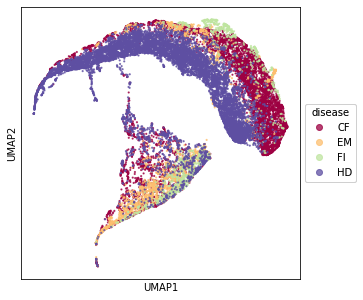

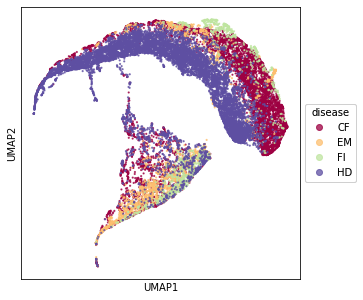

In [29]:
umap_plot(x=proj_2d_lk[:, 0], y=proj_2d_lk[:, 1], c=df_lk["disease"], save="umap_lk_disease.eps")
umap_plot(x=proj_2d_lk[:, 0], y=proj_2d_lk[:, 1], c=df_lk["disease"], save="umap_lk_disease.tif")

### Mean Values per group

In [62]:
#df_lk.groupby(["group"]).mean()[[x + "_raw"  for x in identity_markers+activation_markers]].to_csv("data_lk_mean_perGroup_2024.csv")
df_lk.groupby(["group"]).mean()[[x + "_raw"  for x in identity_markers+activation_markers]]

,CD127-PerCP-Cy5.5_raw,CD94-FITC_raw,CD117-PE_raw,CD294-PerCP-Cy5.5_raw,Lineage-Mix-FITC_raw,CD45_raw,CD336-PE_raw,CD279-FITC_raw,Il-23R-FITC_raw,CD196-PE_raw,CD154-PE_raw,CD278-FITC_raw,CD254-PE_raw,"B7-H2, CD275_raw",CD161-PerCP-Cy5.5_raw,CD253-PE_raw,BAFF_raw,CD40_raw,CD152-PerCP-Cy5.5_raw,CD80-PE_raw
group,,,,,,,,,,,,,,,,,,,,
0,1362.001908,348.893439,148.879495,1034.885953,874.858506,3938.715691,3116.657051,1538.460625,-173.343314,6485.478374,-332.028035,1484.312491,268.987429,6814.838397,756.991412,-1448.884251,240.271246,1538.926462,196.056510,-36.743138
1,1793.563824,766.451441,618.959359,1851.170769,722.412135,12129.702239,3162.958160,1488.215722,267.601984,13456.461791,-460.188514,2493.317878,-243.398399,13246.193665,1055.555838,-1939.876010,-979.971189,2273.019920,152.529670,-148.350887
2,1868.349333,789.909556,1377.075111,1932.635111,114.538667,32065.634222,3337.578125,1556.562796,330.161556,16335.770748,-822.056444,3050.912000,-686.272775,16349.805778,1085.425041,-3191.138133,-2791.173556,1922.533367,368.612889,-12.923111
3,2531.644009,930.076498,20709.781567,677.999770,1559.617742,9611.092671,1572.058411,924.608434,247.526267,7237.684216,7.290783,1133.841014,1222.310843,4491.975780,1050.885984,-328.082623,1991.768433,653.810618,66.494240,108.994470
4,1936.894737,2339.701754,366154.771930,420.824561,1771.140351,21295.052632,3619.183798,1113.829588,78.403509,21895.680908,2392.263158,2162.122807,9995.442160,14102.947368,604.474583,1418.438596,2933.631579,3326.035088,287.350877,1328.543860


In [63]:
#df_lk.groupby(['disease', "group"]).mean()[[x + "_raw"  for x in identity_markers+activation_markers]].to_csv("data_lk_mean_perGroupDisease_2024.csv")
df_lk.groupby(['disease', "group"]).mean()[[x + "_raw"  for x in identity_markers+activation_markers]]

CD127-PerCP-Cy5.5_raw  CD94-FITC_raw   CD117-PE_raw  \
disease group                                                        
CF      0                1019.586743      53.081359    -181.118449   
        1                1070.266719     218.230527       2.011802   
        2                1190.846881     403.374291    2005.338374   
        3                1628.510699     635.289586   23008.802425   
        4                1606.147059    2370.000000  426260.382353   
EM      0                1860.920245    1302.877301     941.288344   
        1                2528.657500    1974.957500    1727.605000   
        2                2372.771429    2085.100000    1730.728571   
        3                4264.051784    1796.706788   26830.004199   
        4                3281.500000    3000.700000  219935.000000   
FI      0                1324.430556     249.620370     464.921296   
        1                1276.502890     291.190751     249.878613   
        2                1481.000000     390.666667     195.666667   
        3                1810.267380     230.344920   13266.859626   
        4                2274.000000    1682.000000  467264.000000   
HD      0                1964.105987     837.648337     672.885588   
        1                2042.998139     883.643300     764.239764   
        2                1951.895764     819.745058    1287.211553   
        3                1651.449409     533.592641   12297.534823   
        4                1725.416667    1757.833333  309279.583333   

               CD294-PerCP-Cy5.5_raw  Lineage-Mix-FITC_raw      CD45_raw  \
disease group                                                              
CF      0                 409.518784           1324.906676   4013.895669   
        1                 476.090480           1718.969315  11316.022817   
        2                 428.967864           1866.682420  31539.612476   
        3                 298.810984           1589.766762  12738.147646   
        4                 349.352941           1884.882353  27571.558824   
EM      0                 687.595092           2531.828221   4118.926380   
        1                1136.837500           2803.827500  12441.738585   
        2                 978.400000           3015.457143  25694.585714   
        3                 787.394682           1964.463961   8404.489287   
        4                 523.800000           2698.400000  10941.400000   
FI      0                1271.898148           2395.652778   4361.574074   
        1                1753.260116           3126.699422  10561.583815   
        2                1704.500000           2850.833333  22536.833333   
        3                 867.895722           2099.871658   4681.152406   
        4                 758.000000           2668.000000  11210.000000   
HD      0                2196.226608           -224.622173   3745.860310   
        1                2492.404467           -186.729839  12580.056141   
        2                2154.356611           -179.778691  32266.253402   
        3                 984.511170            212.831800  10961.553219   
        4                 509.416667            601.416667  12980.083333   

               CD336-PE_raw  CD279-FITC_raw  Il-23R-FITC_raw  CD196-PE_raw  \
disease group                                                                
CF      0       3089.042186     1618.714309      -562.902369   -157.698014   
        1       3089.042186     1618.714309      -457.784422   1829.453973   
        2       3089.042186     1618.714309      -585.871456   3846.013233   
        3       3089.042186     1618.714309      -506.411555   3984.199001   
        4       3089.042186     1618.714309      -423.500000  21220.823529   
EM      0       -264.515337      236.110429       718.361963  11680.981175   
        1        743.650000      901.060000       806.122500  11680.981175   
        2       1374.171429     1007.828571      1086.585714  11680.981175   
        3      -1196.

## LU

In [64]:
df_lu = df[df["organ"] == "LU"]
del df_lu["group"]

In [65]:
from sklearn.neighbors import NearestNeighbors
import igraph
from array import array
import leidenalg

nbrs = NearestNeighbors(n_neighbors=int(15), algorithm='ball_tree').fit(df_lu[identity_markers])
distances, indices = nbrs.kneighbors(df_lu[identity_markers])
knn_sparse_matrix = nbrs.kneighbors_graph() #csr format

#convert to igraph
sources, targets = knn_sparse_matrix.nonzero()
weights = knn_sparse_matrix[sources, targets]
weights = (weights.A)[0] 
knn_graph = igraph.Graph(directed=True)
knn_graph.add_vertices(knn_sparse_matrix.shape[0])  # this adds adjacency.shape[0] vertices
knn_graph.add_edges(list(zip(sources, targets)))

#leiden-algo
partition = leidenalg.find_partition(knn_graph, leidenalg.RBConfigurationVertexPartition, 
                                     resolution_parameter = 0.1,
                                     n_iterations=-1, seed=0) #run until no further improvement 

groups = np.array(partition.membership)
df_lu["group"] = groups
#print(groups)
k = len(np.unique(groups)) #return k
print("Number of Clusters: ", k)

df_lu.disease  = df_lu.disease.astype("category")
df_lu.disease.cat.reorder_categories(['CF', 'EM', 'FI', 'HD'], inplace=True)
#df_lu.to_csv("data_lu_standardised_2024.csv")

Number of Clusters:  3


/tmp/ipykernel_1462226/3819692088.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lu["group"] = groups


### Cells per Cluster (data for Figure 3B)

In [68]:
print("number of cells per cluster:")
df_lu['group'].value_counts()
df_lu.groupby(["disease", "group"]).count()["Size"]

number of cells per cluster:


disease  group
CF       0         840
         1        3224
         2        3259
EM       0          85
         1           0
         2           0
FI       0        1198
         1          77
         2          18
HD       0        1788
         1         303
         2         238
Name: Size, dtype: int64

In [69]:
df_counts = pd.DataFrame(df_lu.groupby(["disease", "group"]).count()["Size"])
df_counts.reset_index(inplace=True)
df_counts["Size"] = pd.to_numeric(df_counts["Size"])
df_counts = df_counts.pivot_table(index='disease',columns='group')
df_counts.columns = df_counts.columns.get_level_values(1)
df_counts

group,0,1,2
disease,,,
CF,840,3224,3259
EM,85,0,0
FI,1198,77,18
HD,1788,303,238


In [70]:
df_counts = pd.DataFrame(df_lk.groupby(["disease", "group"]).count()["Size"])
df_counts.reset_index(inplace=True)
df_counts["Size"] = pd.to_numeric(df_counts["Size"])
pd.crosstab(df_counts["disease"], df_counts["group"], values=df_counts["Size"], aggfunc=np.sum, normalize='columns').applymap(lambda x: "{0:.00f}%".format(100*x))

group,0,1,2,3,4
disease,,,,,
CF,61%,24%,12%,32%,60%
EM,2%,8%,2%,33%,18%
FI,3%,7%,0%,17%,2%
HD,33%,62%,87%,18%,21%


### UMAP (Figure 3A)

In [33]:
import umap.umap_ as umap
df_lu = df_lu.sort_values(by=["disease"])
umap_2d_lu = umap.UMAP(n_components=2,random_state=42) # init='random', 
proj_2d_lu = umap_2d_lu.fit_transform(df_lu[identity_markers])

np.save('umap_lu.npy', proj_2d_lu) # save
#proj_2d_lu = np.load('umap_lu.npy') # load

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


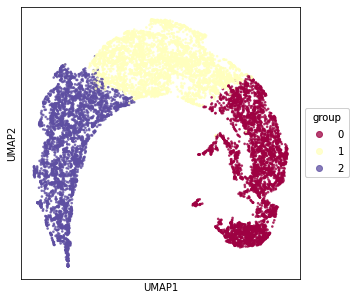

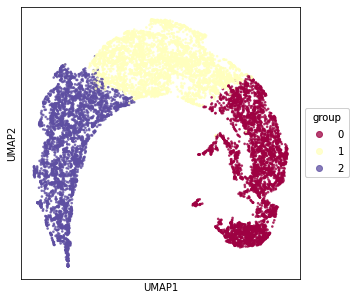

In [35]:
umap_plot(x=proj_2d_lu[:, 0], y=proj_2d_lu[:, 1], c=df_lu["group"], save="umap_lu_group.eps")
umap_plot(x=proj_2d_lu[:, 0], y=proj_2d_lu[:, 1], c=df_lu["group"], save="umap_lu_group.tif")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


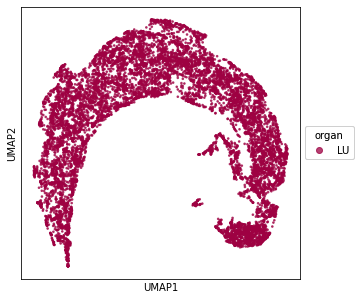

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


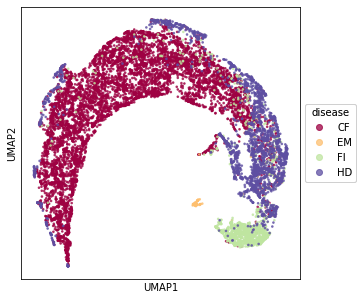

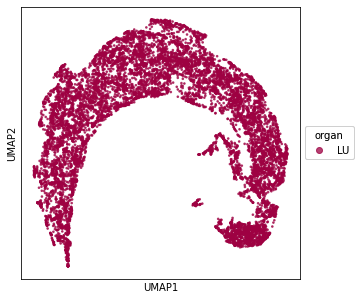

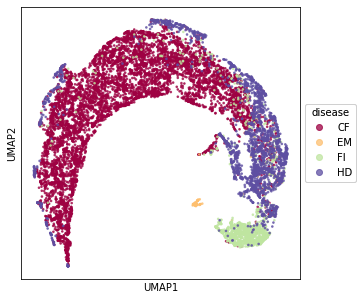

In [36]:
umap_plot(x=proj_2d_lu[:, 0], y=proj_2d_lu[:, 1], c=df_lu["organ"], save="umap_lu_organ.eps")
umap_plot(x=proj_2d_lu[:, 0], y=proj_2d_lu[:, 1], c=df_lu["disease"], save="umap_lu_disease.eps")
umap_plot(x=proj_2d_lu[:, 0], y=proj_2d_lu[:, 1], c=df_lu["organ"], save="umap_lu_organ.tif")
umap_plot(x=proj_2d_lu[:, 0], y=proj_2d_lu[:, 1], c=df_lu["disease"], save="umap_lu_disease.tif")

### Mean Values

In [91]:
#df_lu.groupby(["group"]).mean()[[x + "_raw"  for x in identity_markers+activation_markers]].to_csv("data_lu_mean_perGroup_2024.csv")
df_lu.groupby(["group"]).mean()[[x + "_raw"  for x in identity_markers+activation_markers]]

,CD127-PerCP-Cy5.5_raw,CD94-FITC_raw,CD117-PE_raw,CD294-PerCP-Cy5.5_raw,Lineage-Mix-FITC_raw,CD45_raw,CD336-PE_raw,CD279-FITC_raw,Il-23R-FITC_raw,CD196-PE_raw,CD154-PE_raw,CD278-FITC_raw,CD254-PE_raw,"B7-H2, CD275_raw",CD161-PerCP-Cy5.5_raw,CD253-PE_raw,BAFF_raw,CD40_raw,CD152-PerCP-Cy5.5_raw,CD80-PE_raw
group,,,,,,,,,,,,,,,,,,,,
0,2551.513168,2375.792636,3412.980565,1125.094861,2767.072871,6492.981590,4301.355717,1844.186397,1712.762976,15473.845049,-1320.058808,1429.100662,2670.380474,7857.483294,524.381844,1123.381997,5649.915878,2781.342112,360.285533,467.533112
1,2185.336848,5595.321587,1901.945036,1965.120144,5564.478080,23704.754162,3099.729620,1513.807714,2188.252775,13067.996741,-329.543008,5994.138180,4536.525724,9568.644830,911.656450,-863.770677,-2394.456992,-1481.055494,457.100904,2788.748890
2,2076.091323,8078.584922,2405.815502,2092.417923,7704.278236,53311.546799,3111.708009,2770.308393,3442.643528,12822.969744,-1172.484495,9908.210242,7392.534585,9664.174775,1003.635309,-1353.484957,-7764.312660,-3817.612233,486.831826,5496.100996


In [92]:
#df_lu.groupby(['disease', "group"]).mean()[[x + "_raw"  for x in identity_markers+activation_markers]].to_csv("data_lu_mean_perGroupDisease_2024.csv")
df_lu.groupby(['disease', "group"]).mean()[[x + "_raw"  for x in identity_markers+activation_markers]]

CD127-PerCP-Cy5.5_raw  CD94-FITC_raw  CD117-PE_raw  \
disease group                                                       
CF      0                1870.325000    3217.111905   9639.975000   
        1                2173.224256    6027.872829   2007.915323   
        2                2057.544646    8589.853329   2498.871433   
EM      0               17544.576471   10731.670588   4895.258824   
        1                        NaN            NaN           NaN   
        2                        NaN            NaN           NaN   
FI      0                2392.937396    2696.964107   2144.327212   
        1                2048.610390    3305.662338    826.571429   
        2                2414.944444    5307.166667    922.888889   
HD      0                2265.026286    1368.118568   1267.106819   
        1                2348.963696    1574.722772   1047.672971   
        2                2304.428571    1287.247899   1243.728947   

               CD294-PerCP-Cy5.5_raw  Lineage-Mix-FITC_raw      CD45_raw  \
disease group                                                              
CF      0                1694.733333           3517.354762  10979.788095   
        1                2123.842122           5867.791253  23845.793734   
        2                2209.444922           8097.294569  52819.560295   
EM      0                5965.976471          10936.788235   1657.564706   
        1                        NaN                   NaN           NaN   
        2                        NaN                   NaN           NaN   
FI      0                1487.117696           1565.045910   2055.388982   
        1                1567.948052           3014.025974  21341.103896   
        2                2126.833333           3673.055556  43317.000000   
HD      0                 384.784676           2831.595078   7588.243848   
        1                 377.207921           2985.280528  22804.719472   
        2                 487.331933           2627.478992  60804.344538   

               CD336-PE_raw  CD279-FITC_raw  Il-23R-FITC_raw   CD196-PE_raw  \
disease group                                                                 
CF      0       3089.042186      681.584524       830.372619   11680.981175   
        1       3089.042186     1458.860112      2250.344293   11680.981175   
        2       3089.042186     2857.442467      3575.711568   11680.981175   
EM      0       1009.258824     2836.223529      1801.105882   26392.917647   
        1               NaN             NaN              NaN            NaN   
        2               NaN             NaN              NaN            NaN   
FI      0       7194.334178     2863.051753      2406.086811   12566.984807   
        1       3589.269602     2314.493506      1077.506494   45436.168098   
        2       7515.173698     2077.944444      1767.388889  109473.055556   
HD      0       3089.042186     1660.552013      1658.566555   18684.305369   
        1       3089.042186     1894.990099      1809.851485   19600.633663   
        2       3089.042186     1629.521008      1747.205882   21150.865546   

               CD154-PE_raw  CD278-FITC_raw  CD254-PE_raw  B7-H2, CD275_raw  \
disease group                                                                 
CF      0        -37.641667     3165.258333   2677.546429       9659.221142   
        1       -266.002481     6624.039082   4850.231390       9659.221142   
        2      -1172.205891    10651.183799   7833.740411       9659.221142   
EM      0       1630.400000     4545.611765     81.552941       1622.352941   
        1               NaN             NaN           NaN               NaN   
        2               NaN             NaN           NaN               NaN   
FI      0      -3149.338898     1578.483881   4215.469115       4347.482471   
        1      -1066.467532     1542.402597   2347.740260       5419.779221   
        2      -3955.833333     2500.444444   2052.611111      10626.555556   
HD     

# Save

In [40]:
%%bash
jupyter nbconvert --to html_toc log10Data_2024data.ipynb --ExtractOutputPreprocessor.enabled=False
mv log10Data_2024data.html ./log10Data_2024data_$(date +%Y%m%d).html 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook log10Data_2024data.ipynb to html_toc
[NbConvertApp] Writing 17387467 bytes to log10Data_2024data.html
